In [4]:
import sys

import sklearn

import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import matplotlib.animation as animation

[handson-ml3](https://github.com/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb)に沿って進める

# Introduction to OpenAI gym

[github](https://github.com/openai/gym)

In [5]:
import gym

In [6]:
envs=gym.envs.registry
sorted(envs.keys())[:5]+["..."]

['ALE/Adventure-ram-v5',
 'ALE/Adventure-v5',
 'ALE/AirRaid-ram-v5',
 'ALE/AirRaid-v5',
 'ALE/Alien-ram-v5',
 '...']

In [7]:
envs['CartPole-v1']

EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1)

In [8]:
env=gym.make('CartPole-v1',render_mode='rgb_array')

In [9]:
obs, info =env.reset(seed=42)

In [10]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [11]:
info

{}

In [12]:
try:
    import pyvirtualdisplay
    display= pyvirtualdisplay.Display(visible=0, size=(1400,900)).start()
except ImportError:
    pass

In [13]:
img= env.render()
img.shape

(400, 600, 3)

In [14]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img=env.render()
    plt.imshow(img)
    plt.axis('off')
    return img

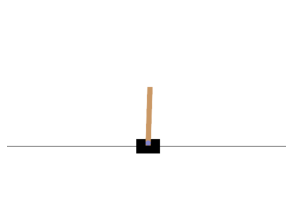

In [15]:
plot_environment(env)
plt.show()

In [16]:
env.action_space

Discrete(2)

In [17]:
action=1
obs, reward, done, truncated, info=env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

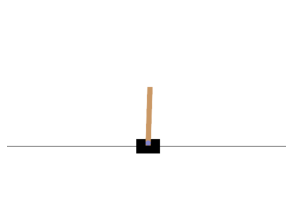

In [18]:
plot_environment(env)
plt.show()

reward:報酬、最終ステップに対していくらの報酬が得られたか

In [19]:
reward

1.0

done:ゲームが終了したかどうか

In [20]:
done

False

truncated:環境を中断した時にTrueになる

In [21]:
truncated

False

info:環境特有の情報を辞書型で与える。デバッグや訓練に有用。

In [22]:
info

{}

エピソードの最後まで達したら環境をリセットする必要がある。

In [23]:
if done:
    obs, info=env.reset()

# A simple hard-coded policy

In [24]:
def basic_policy(obs):
    angle=obs[2]
    return 0 if angle <0 else 1

totals=[]
for episode in range(500):
    episode_rewards=0
    obs, info=env.reset(seed = episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done,truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
    totals.append(episode_rewards)



In [25]:
np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

[animation](https://github.com/ageron/handson-ml3/blob/a858c72c76d42285d73c7f3b21dc9f4302c4bd26//tools_matplotlib.ipynb#Animations)

In [26]:

x = np.linspace(-1, 1, 100)
y = np.sin(x**2*25)
data = np.array([x, y])

fig = plt.figure()
line, = plt.plot([], [], "r-")  # start with an empty plot
plt.axis([-1.1, 1.1, -1.1, 1.1])
plt.plot([-0.5, 0.5], [0, 0], "b-", [0, 0], [-0.5, 0.5], "b-", 0, 0, "ro")
plt.grid(True)
plt.title("Marvelous animation")

# this function will be called at every iteration
def update_line(num, data, line):
    # we only plot the first `num` data points.
    line.set_data(data[..., :num] + np.random.rand(2, num) / 25)
    return line,

line_ani = animation.FuncAnimation(fig, update_line, frames=50,
                                   fargs=(data, line), interval=100)
plt.close()  # call close() to avoid displaying the static plot

In [27]:
from IPython.display import HTML

In [28]:
HTML(line_ani.to_jshtml())
mpl.rc('animation', html='jshtml')

In [29]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig=plt.figure()
    patch=plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch), 
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames=[]
    env=gym.make('CartPole-v1', render_mode='rgb_array')
    np.random.seed(seed)
    obs, info=env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action=policy(obs)
        obs, reward, done, truncated, info=env.step(action)
        if done or truncated:
            break
        env.close()
        return plot_animation(frames)

show_one_episode(basic_policy)


# Neural Network Policies

In [30]:
tf.random.set_seed(42)

model=tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [32]:
def pg_policy(obs):
    left_proba=model.predict(obs[np.newaxis], verbose=0)
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

# Policy Gradients

In [33]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action=(tf.random.uniform([1,1])> left_proba)
        y_target=tf.constant([[1.]]) -tf.cast(action, tf.float32)
        loss=tf.reduce_mean(loss_fn(y_target, left_proba))
    
    grads=tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

In [34]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards=[]
    all_grads=[]
    for episode in range(n_episodes):
        current_rewards=[]
        current_grads=[]
        obs, info =env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads=play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads
    